# Analisis descriptivo

### Importacion de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)


## Carga de excel y datos.

In [4]:
excel_file = "datos_ecoli.xlsx" 
df = pd.read_excel(excel_file, sheet_name=0) 

print("\n=== Columnas originales ===")
print(df.columns.tolist())



=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T

### Limpieza de las columnas de los datos.

In [8]:
new_col_names = []
#Limpieza de columnas de los datos.
for col in df.columns:
    clean_name = col.split(',', 1)[0]
    new_col_names.append(clean_name)

df.columns = new_col_names

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())



=== Columnas luego de limpiarlas ===
['PATIENT_ID', 'SEX', 'DATE_BIRTH', 'AGE', 'WARD', 'SPEC_DATE', 'SPEC_TYPE', 'ORGANISM', 'ESBL', 'CARBAPENEM', 'X_IAD', 'X_APB', 'X_EDTA', 'X_THM', 'X_ISO', 'X_CARBA_NP', 'X_XPERT', 'X_MCIM', 'X_ECIM', 'X_GEN_CARB', 'X_ICR', 'X_OXSF', 'X_VIGILANC', 'X_HODGE', 'NOSOCOMIAL', 'X_CARB_NP', 'AMK_NM', 'AMB_NM', 'AMP_NM', 'SAM_NM', 'ATM_NM', 'CAS_NM', 'CZO_NM', 'FEP_NM', 'CTX_NM', 'FOX_NM', 'CAZ_NM', 'CRO_NM', 'CXM_NM', 'CXA_NM', 'CEP_NM', 'CIP_NM', 'CLI_NM', 'COL_NM', 'DOR_NM', 'ETP_NM', 'ERY_NM', 'FLU_NM', 'FOS_NM', 'GEN_NM', 'GEH_NM', 'IPM_NM', 'LVX_NM', 'LNZ_NM', 'MEM_NM', 'MIF_NM', 'MNO_NM', 'MFX_NM', 'NIT_NM', 'NOR_NM', 'OXA_NM', 'TZP_NM', 'QDA_NM', 'RIF_NM', 'STH_NM', 'TEC_NM', 'TCY_NM', 'TGC_NM', 'SXT_NM', 'VAN_NM', 'VOR_NM', 'FCT_NM', 'NAL_NM', 'AMC_NM', 'CFM_NM', 'PEN_NM', 'MIF_ND', 'MIF_NE', 'DAP_NM', 'CZA_NM', 'SXT_ND1_2', 'AZM_NM', 'CFP_NM', 'CHL_NM', 'STR_NM', 'OFX_NM', 'TLT_NM', 'ATM_NE', 'TZP_NE', 'TGC_NE', 'TOB_NM', 'AMX_NM', 'DOR_ND10', 

## Analisis descriptivo

In [40]:
import pandas as pd
import numpy as np

# Supongamos que el DataFrame ya está cargado en la variable df
# Si necesitas cargarlo desde un archivo, descomenta y ajusta la siguiente línea:
# df = pd.read_csv('ruta_al_archivo.csv')

# Convertir las columnas de fecha a formato datetime
df['DATE_BIRTH'] = pd.to_datetime(df['DATE_BIRTH'])
df['SPEC_DATE'] = pd.to_datetime(df['SPEC_DATE'])
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')

# 1. Descripción General del DataFrame
print("=== Descripción General ===")
print(f"Tamaño del DataFrame: {df.shape}")
print("\nTipos de datos:")
print(df.dtypes)
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# 2. Análisis Univariado

# Función para analizar variables categóricas
def analizar_categorica(columna):
    print(f"\n--- Análisis de '{columna}' ---")
    print("Frecuencia absoluta:")
    print(df[columna].value_counts())
    print("\nFrecuencia relativa (%):")
    print(df[columna].value_counts(normalize=True) * 100)
    print(f"Moda: {df[columna].mode()[0]}")

# Variables categóricas
categoricas = ['SEX', 'WARD', 'SPEC_TYPE', 'ORGANISM', 'ESBL']
for col in categoricas:
    analizar_categorica(col)

# Análisis de la variable numérica 'AGE'
print("\n--- Análisis de 'AGE' ---")
print(f"Media: {df['AGE'].mean():.2f}")
print(f"Mediana: {df['AGE'].median():.2f}")
print(f"Desviación estándar: {df['AGE'].std():.2f}")
print(f"Mínimo: {df['AGE'].min()}")
print(f"Máximo: {df['AGE'].max()}")
print("Cuartiles:")
print(df['AGE'].quantile([0.25, 0.5, 0.75]))

# Función para analizar variables de fecha
def analizar_fecha(columna):
    print(f"\n--- Análisis de '{columna}' ---")
    print(f"Rango de fechas: {df[columna].min()} a {df[columna].max()}")
    print("\nFrecuencia por año:")
    print(df[columna].dt.year.value_counts().sort_index())

# Analizar columnas de fecha
analizar_fecha('DATE_BIRTH')
analizar_fecha('SPEC_DATE')

# Verificar unicidad de 'PATIENT_ID'
print("\n--- Análisis de 'PATIENT_ID' ---")
duplicados = df['PATIENT_ID'].duplicated().sum()
print(f"Número de IDs duplicados: {duplicados}")
if duplicados == 0:
    print("Todos los IDs son únicos.")
else:
    print("Hay IDs duplicados. Revisa los datos.")

# 3. Análisis Bivariado (Opcional)

# Media de edad por género
print("\n--- Media de edad por género ---")
print(df.groupby('SEX')['AGE'].mean())

# Tabla de contingencia entre 'ORGANISM' y 'WARD'
print("\n--- Tabla de contingencia ORGANISM vs WARD ---")
print(pd.crosstab(df['WARD'], df['ORGANISM']))

# Porcentaje de ESBL positivo por organismo
print("\n--- Porcentaje de ESBL positivo por ORGANISM ---")
esbl_por_organismo = pd.crosstab(df['ORGANISM'], df['ESBL'], normalize='index') * 100
print(esbl_por_organismo)

# Fin del análisis
print("\n=== Fin del análisis descriptivo ===")

=== Descripción General ===
Tamaño del DataFrame: (7665, 143)

Tipos de datos:
PATIENT_ID            object
SEX                   object
DATE_BIRTH    datetime64[ns]
AGE                  float64
WARD                  object
                   ...      
TCY_ND30             float64
TEC_ND30             float64
TGC_ND15             float64
X_1_NM               float64
ESBL_bin             float64
Length: 143, dtype: object

Valores faltantes por columna:
PATIENT_ID       0
SEX              0
DATE_BIRTH       0
AGE            421
WARD             0
              ... 
TCY_ND30      7665
TEC_ND30      7665
TGC_ND15      7665
X_1_NM        7665
ESBL_bin         0
Length: 143, dtype: int64

--- Análisis de 'SEX' ---
Frecuencia absoluta:
SEX
f    5757
m    1908
Name: count, dtype: int64

Frecuencia relativa (%):
SEX
f    75.107632
m    24.892368
Name: proportion, dtype: float64
Moda: f

--- Análisis de 'WARD' ---
Frecuencia absoluta:
WARD
urgmix    5015
c.ext     1320
5piso      198
1/2adu    

## Graficas.

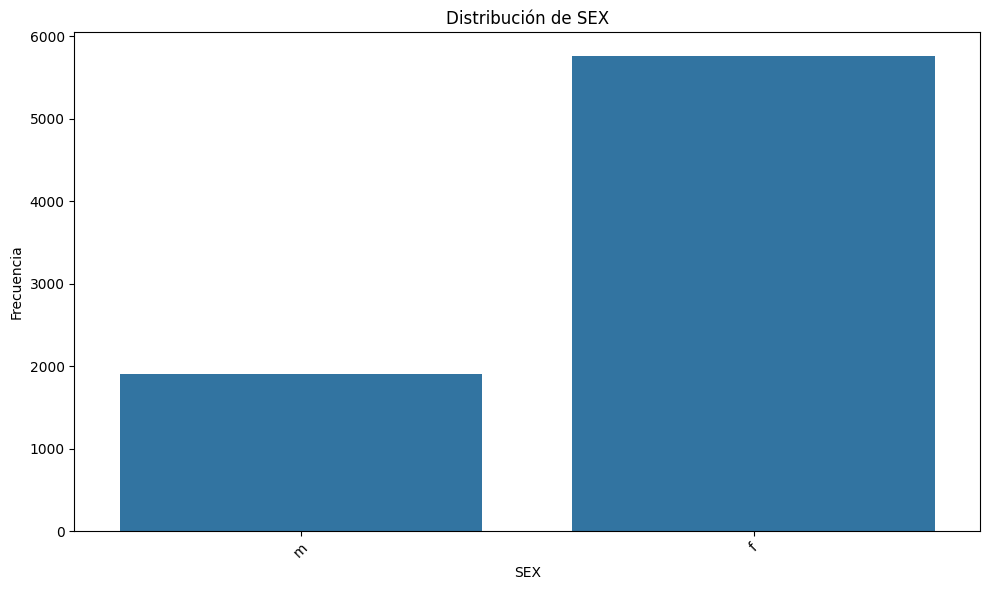

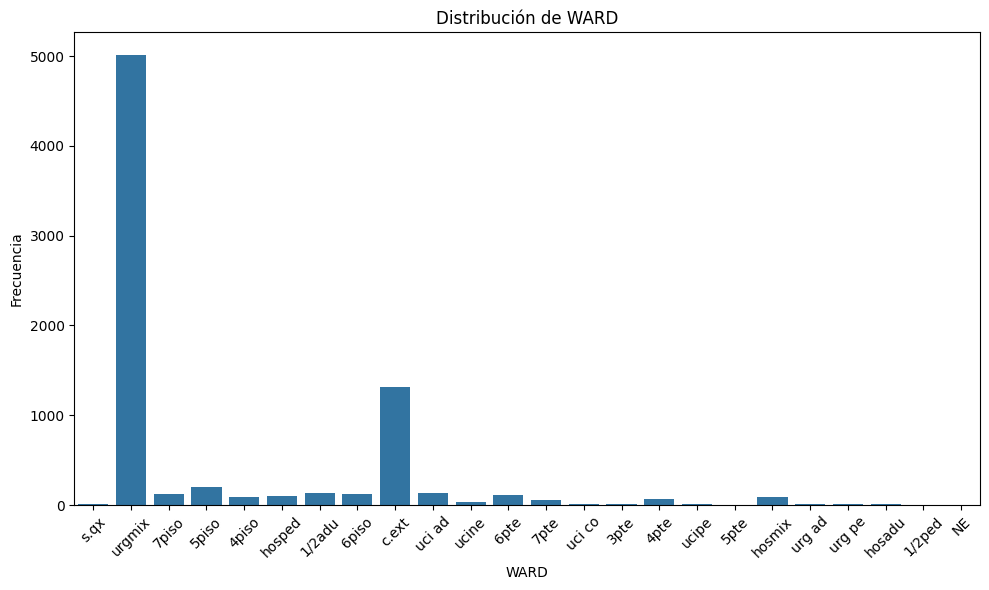

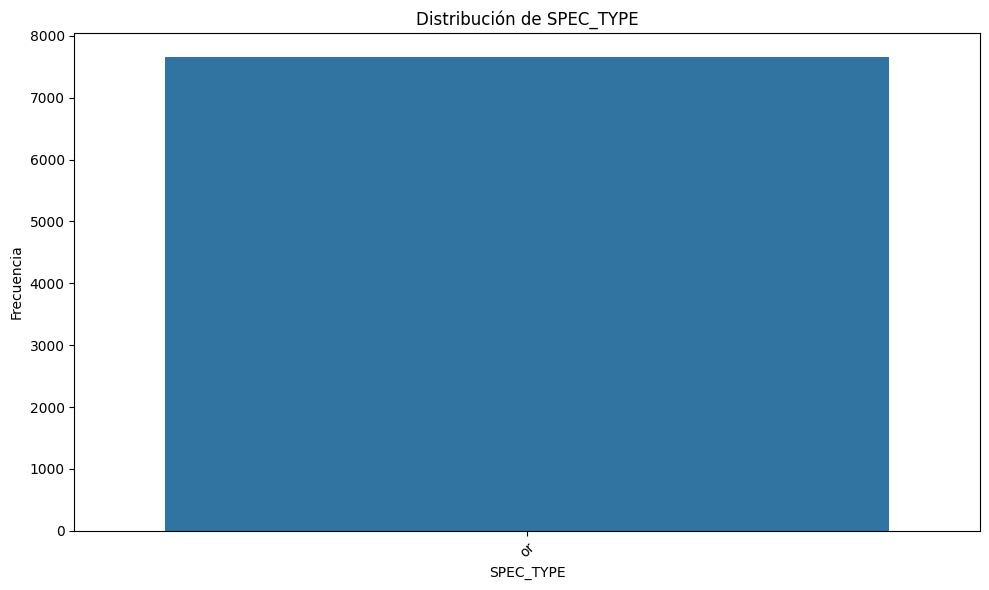

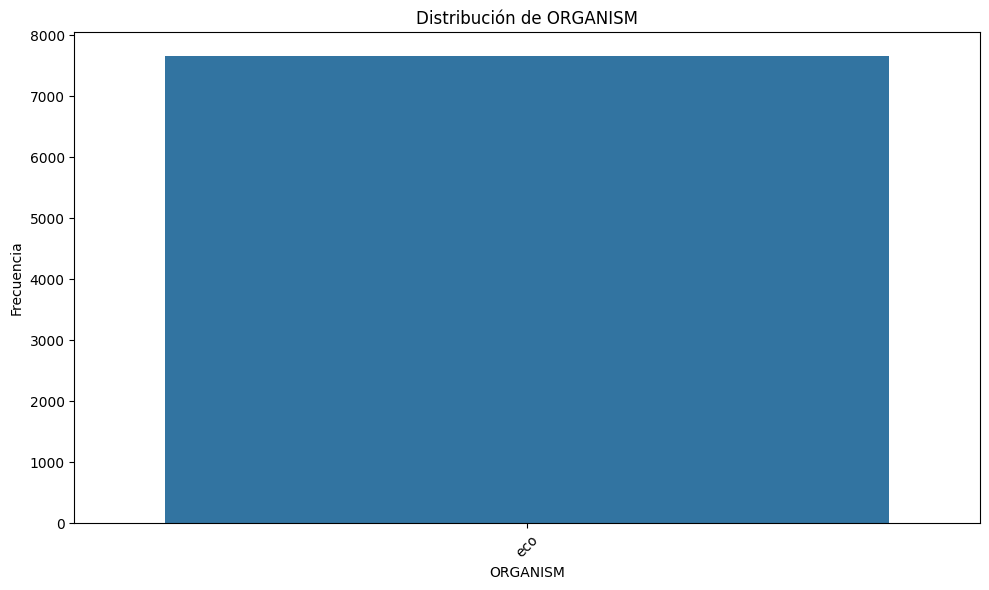

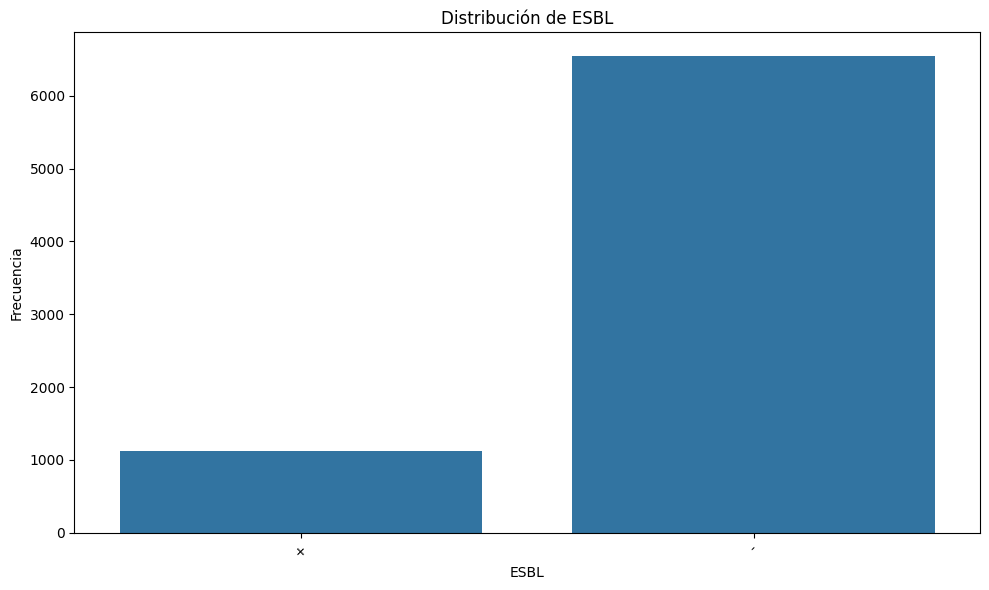

In [41]:
# Lista de variables categóricas
categoricas = ['SEX', 'WARD', 'SPEC_TYPE', 'ORGANISM', 'ESBL']

# Función para graficar variables categóricas
def graficar_categorica(columna):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=columna)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Graficar cada variable categórica
for col in categoricas:
    graficar_categorica(col)

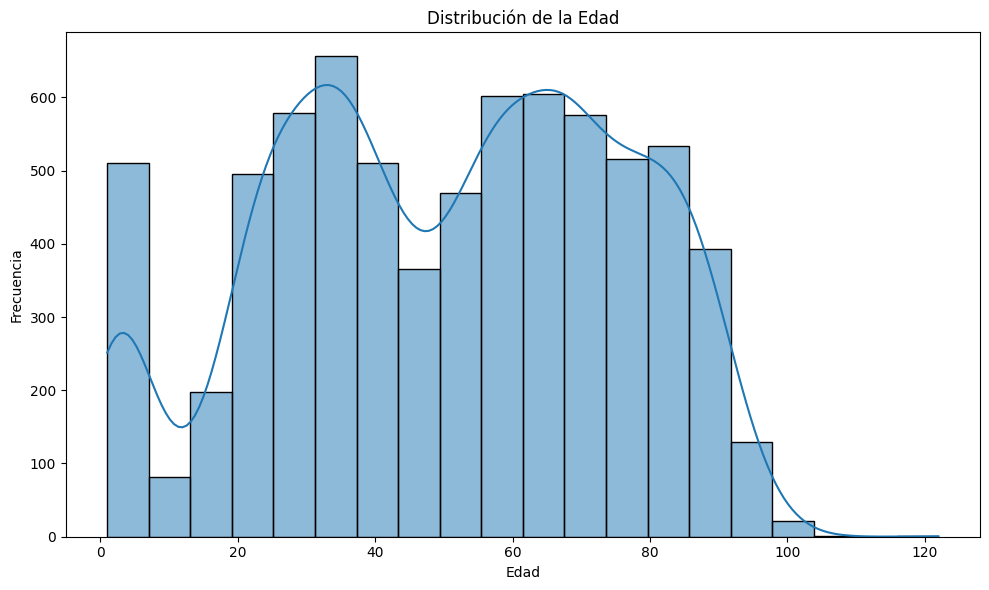

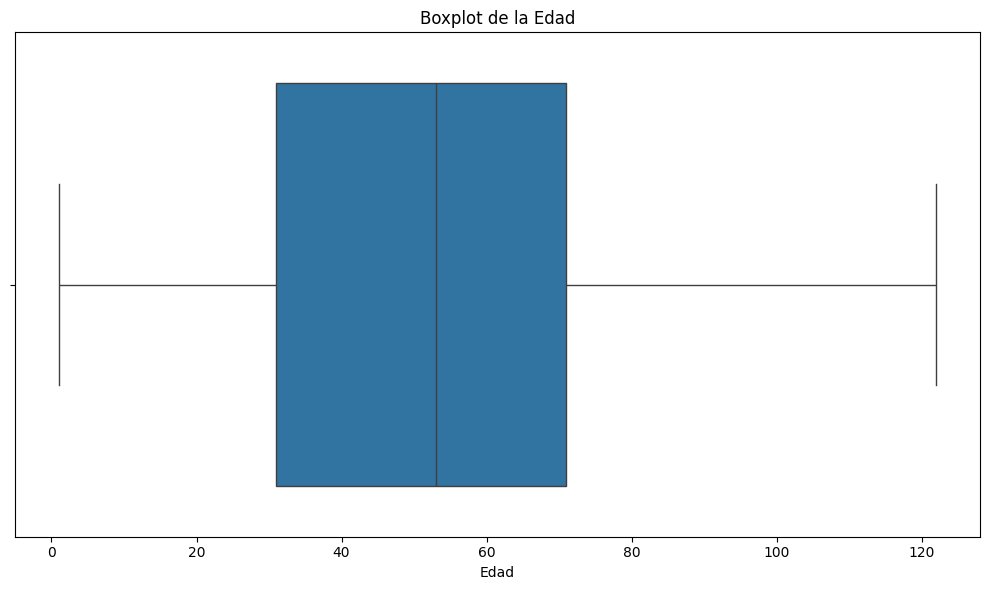

In [42]:
# Histograma de 'AGE'
plt.figure(figsize=(10, 6))
sns.histplot(df['AGE'], bins=20, kde=True)  # kde=True agrega la curva de densidad
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplot de 'AGE'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['AGE'])
plt.title('Boxplot de la Edad')
plt.xlabel('Edad')
plt.tight_layout()
plt.show()

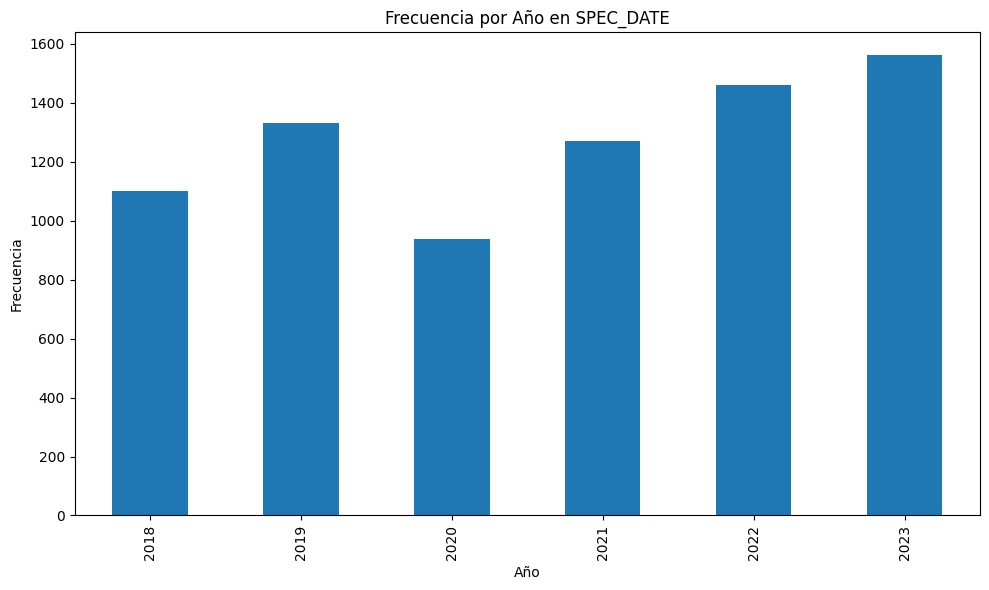

In [44]:
# Función para graficar frecuencia por año
def graficar_fecha(columna):
    plt.figure(figsize=(10, 6))
    df[columna].dt.year.value_counts().sort_index().plot(kind='bar')
    plt.title(f'Frecuencia por Año en {columna}')
    plt.xlabel('Año')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

# Graficar para 'DATE_BIRTH' y 'SPEC_DATE'
graficar_fecha('SPEC_DATE')

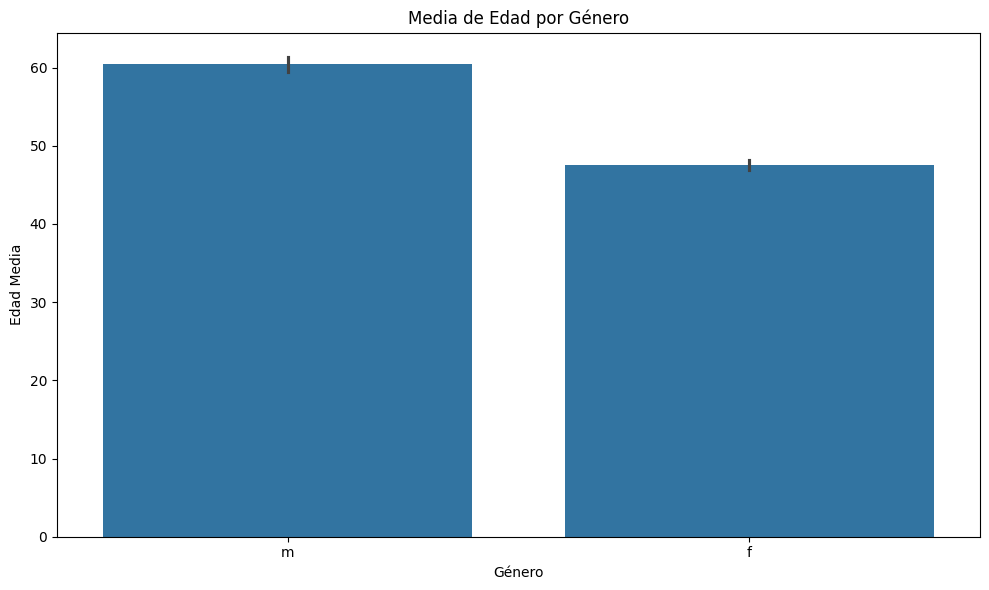

In [45]:
# Gráfico de barras para media de edad por género
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='SEX', y='AGE', estimator=np.mean)
plt.title('Media de Edad por Género')
plt.xlabel('Género')
plt.ylabel('Edad Media')
plt.tight_layout()
plt.show()

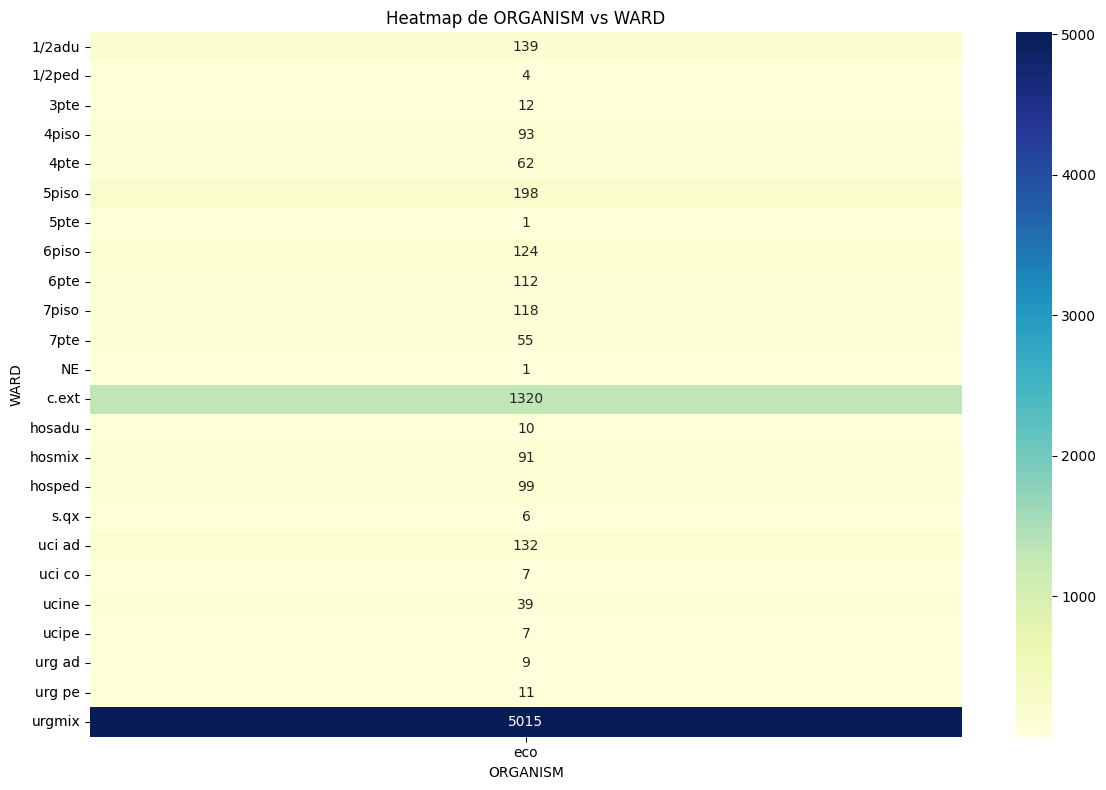

In [46]:
# Tabla de contingencia
contingencia = pd.crosstab(df['WARD'], df['ORGANISM'])

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingencia, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap de ORGANISM vs WARD')
plt.xlabel('ORGANISM')
plt.ylabel('WARD')
plt.tight_layout()
plt.show()

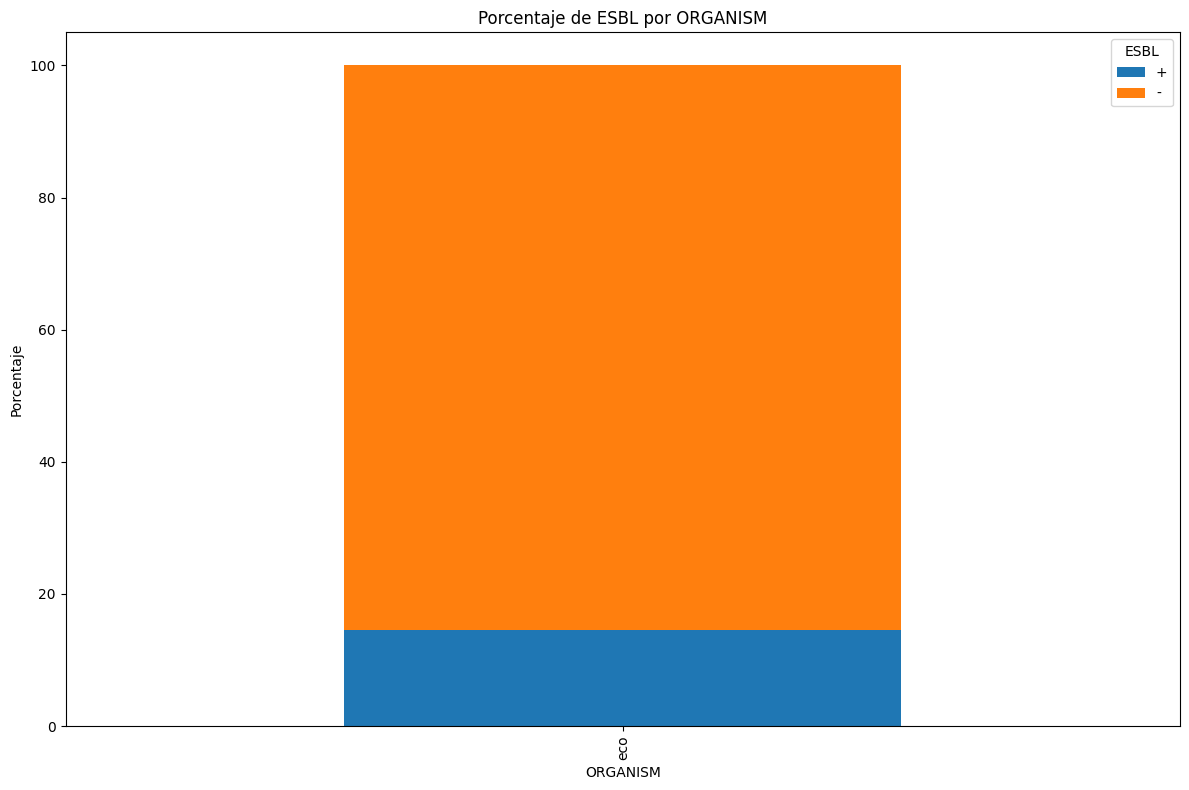

In [47]:
# Tabla de porcentajes
esbl_por_organismo = pd.crosstab(df['ORGANISM'], df['ESBL'], normalize='index') * 100

# Gráfico de barras apiladas
esbl_por_organismo.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Porcentaje de ESBL por ORGANISM')
plt.xlabel('ORGANISM')
plt.ylabel('Porcentaje')
plt.legend(title='ESBL')
plt.tight_layout()
plt.show()

### Parseo de valores. Teniendo en cuenta que se manejan intervalos.

In [13]:
def parse_mic_no_round(value):
    """
    Convierte valores con símbolos <= o > en un número flotante, evitando redondeos
    o multiplicaciones. Para valores '>x', se suma un pequeño delta (0.0001).
    Ejemplo: '<=2' -> 2.0, '>16' -> 16.0001
    Ajusta la lógica (y el delta) según tus criterios de laboratorio.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    
    val_str = str(value).strip().lower()

    # Caso: "<=x"
    if val_str.startswith('<='):
        try:
            # Eliminar la parte "<=" y convertir a float
            return float(val_str.replace('<=', ''))
        except:
            return np.nan

    # Caso: ">x"
    elif val_str.startswith('>'):
        try:
            # Eliminar la parte ">" y convertir a float, luego sumarle un delta
            base_val = float(val_str.replace('>', ''))
            return base_val + 0.0001
        except:
            return np.nan

    # Caso: Valor numérico directo
    else:
        try:
            return float(val_str)
        except:
            return np.nan


### Tomar enzimas de interes

In [15]:
# Seleccionar columnas de interés
cols_enzimas = [
        'CARBAPENEM', 'X_IAD', 'X_APB', 'X_EDTA', 'X_THM', 'X_ISO',
        'X_CARBA_NP', 'X_XPERT', 'X_MCIM', 'X_ECIM', 'X_GEN_CARB', 'X_ICR',
        'X_OXSF', 'X_VIGILANC', 'X_HODGE', 'NOSOCOMIAL', 'X_CARB_NP',
        'AMK_NM', 'AMB_NM', 'AMP_NM', 'SAM_NM', 'ATM_NM', 'CAS_NM',
        'CZO_NM', 'FEP_NM', 'CTX_NM', 'FOX_NM', 'CAZ_NM', 'CRO_NM',
        'CXM_NM', 'CXA_NM', 'CEP_NM', 'CIP_NM', 'CLI_NM', 'COL_NM',
        'DOR_NM', 'ETP_NM', 'ERY_NM', 'FLU_NM', 'FOS_NM', 'GEN_NM',
        'GEH_NM', 'IPM_NM', 'LVX_NM', 'LNZ_NM', 'MEM_NM', 'MIF_NM',
        'MNO_NM', 'MFX_NM', 'NIT_NM', 'NOR_NM', 'OXA_NM', 'TZP_NM',
        'QDA_NM', 'RIF_NM', 'STH_NM', 'TEC_NM', 'TCY_NM', 'TGC_NM',
        'SXT_NM', 'VAN_NM', 'VOR_NM', 'FCT_NM', 'NAL_NM', 'AMC_NM',
        'CFM_NM', 'PEN_NM', 'MIF_ND', 'MIF_NE', 'DAP_NM', 'CZA_NM',
        'SXT_ND1_2', 'AZM_NM', 'CFP_NM', 'CHL_NM', 'STR_NM', 'OFX_NM',
        'TLT_NM', 'ATM_NE', 'TZP_NE', 'TGC_NE', 'TOB_NM', 'AMX_NM',
        'DOR_ND10', 'ATM_ND30', 'ETP_ND10', 'AMK_ND30', 'CIP_ND5',
        'SAM_ND10', 'IPM_ND10', 'MEM_ND10', 'CAZ_ND30', 'CTX_ND30',
        'FEP_ND30', 'TZP_ND100', 'CRO_ND30', 'NAL_ND30', 'AMP_ND10',
        'CZO_ND30', 'GEN_ND10', 'CLI_ND2', 'NIT_ND300', 'NOR_ND10',
        'OXA_ND1', 'VAN_ND30', 'ITR_NM', 'DOR_NE', 'DAP_NE', 'IPM_NE',
        'MEM_NE', 'VAN_NE', 'AMC_ND20', 'AMX_ND25', 'FOX_ND30',
        'CEP_ND30', 'CXM_ND30', 'CHL_ND30', 'COL_ND10', 'DAP_ND30',
        'ERY_ND15', 'FUS_ND50', 'GEH_ND120', 'LNZ_ND30', 'LVX_ND5',
        'MFX_ND5', 'MUP_ND5', 'PEN_ND10', 'RIF_ND5', 'STH_ND300',
        'TCY_ND30', 'TEC_ND30', 'TGC_ND15', 'X_1_NM'
    ]

# Ver cuáles de esas columnas existen en el DataFrame
cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")

# (Opcional) Parsear dichas columnas si tienen el formato <=, >
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic_no_round)



Columnas de interés presentes en el DataFrame: ['CARBAPENEM', 'X_IAD', 'X_APB', 'X_EDTA', 'X_THM', 'X_ISO', 'X_CARBA_NP', 'X_XPERT', 'X_MCIM', 'X_ECIM', 'X_GEN_CARB', 'X_ICR', 'X_OXSF', 'X_VIGILANC', 'X_HODGE', 'NOSOCOMIAL', 'X_CARB_NP', 'AMK_NM', 'AMB_NM', 'AMP_NM', 'SAM_NM', 'ATM_NM', 'CAS_NM', 'CZO_NM', 'FEP_NM', 'CTX_NM', 'FOX_NM', 'CAZ_NM', 'CRO_NM', 'CXM_NM', 'CXA_NM', 'CEP_NM', 'CIP_NM', 'CLI_NM', 'COL_NM', 'DOR_NM', 'ETP_NM', 'ERY_NM', 'FLU_NM', 'FOS_NM', 'GEN_NM', 'GEH_NM', 'IPM_NM', 'LVX_NM', 'LNZ_NM', 'MEM_NM', 'MIF_NM', 'MNO_NM', 'MFX_NM', 'NIT_NM', 'NOR_NM', 'OXA_NM', 'TZP_NM', 'QDA_NM', 'RIF_NM', 'STH_NM', 'TEC_NM', 'TCY_NM', 'TGC_NM', 'SXT_NM', 'VAN_NM', 'VOR_NM', 'FCT_NM', 'NAL_NM', 'AMC_NM', 'CFM_NM', 'PEN_NM', 'MIF_ND', 'MIF_NE', 'DAP_NM', 'CZA_NM', 'SXT_ND1_2', 'AZM_NM', 'CFP_NM', 'CHL_NM', 'STR_NM', 'OFX_NM', 'TLT_NM', 'ATM_NE', 'TZP_NE', 'TGC_NE', 'TOB_NM', 'AMX_NM', 'DOR_ND10', 'ATM_ND30', 'ETP_ND10', 'AMK_ND30', 'CIP_ND5', 'SAM_ND10', 'IPM_ND10', 'MEM_ND10', 'CA

### Preparacion variable objetivo

In [16]:
if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame (ya limpia).")
    
df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])  # Quita filas donde ESBL_bin sea NaN


### Imputar valores vacios

In [17]:
# Construir matriz X, y para el modelo
X = df[cols_presentes].copy()  # Features
y = df["ESBL_bin"].copy()      # Objetivo

# Rellenar valores faltantes con la media de cada columna
X = X.fillna(X.mean())


### Entrenamiento del modelo


=== MATRIZ DE CONFUSIÓN ===
[[1309    2]
 [  12  210]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1311
           1       0.99      0.95      0.97       222

    accuracy                           0.99      1533
   macro avg       0.99      0.97      0.98      1533
weighted avg       0.99      0.99      0.99      1533



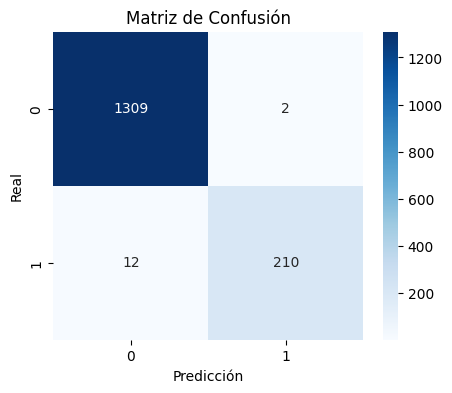

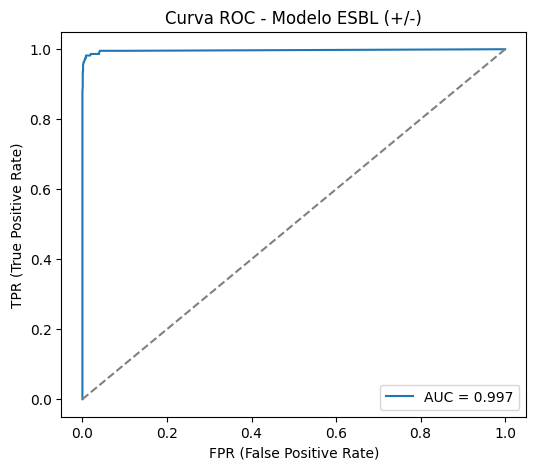

In [18]:
# Entrenar modelo (Random Forest) y evaluar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_pred)
print("\n=== MATRIZ DE CONFUSIÓN ===")
print(cm)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Modelo ESBL (+/-)")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.show()


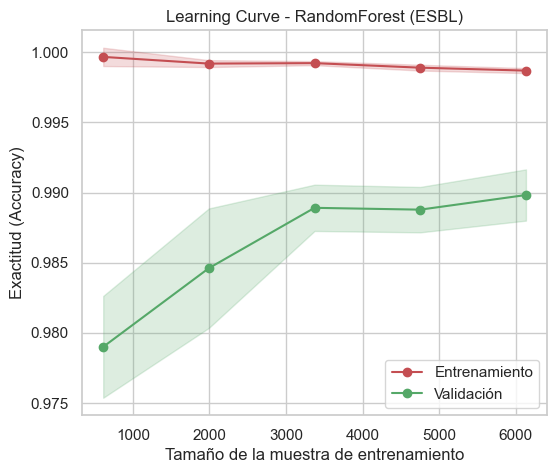

In [32]:
# Learning curve (evolución con tamaño de entrenamiento)
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2, color="r")

plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.2, color="g")

plt.title("Learning Curve - RandomForest (ESBL)")
plt.xlabel("Tamaño de la muestra de entrenamiento")
plt.ylabel("Exactitud (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### Importacia de las variables


=== IMPORTANCIA DE LAS 10 CARACTERÍSTICAS MÁS RELEVANTES ===
FEP_NM    0.244383
ATM_NM    0.208789
CAZ_NM    0.171788
CRO_NM    0.105151
CZO_NM    0.052876
CIP_NM    0.042332
CEP_NM    0.027561
SAM_NM    0.024576
AMK_NM    0.016792
TZP_NM    0.012913
dtype: float64


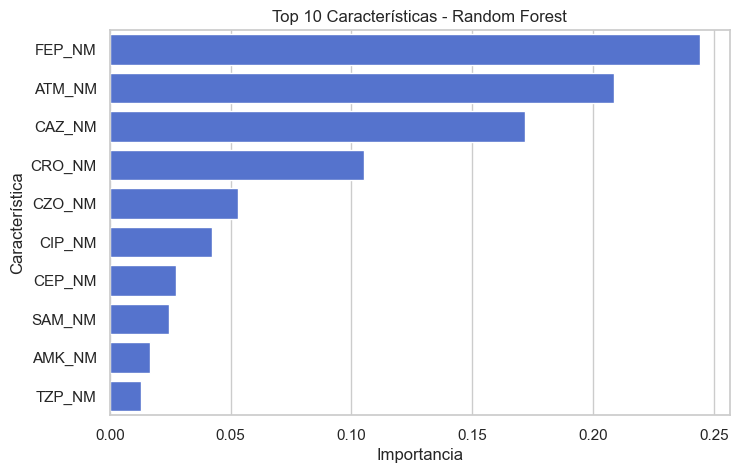


=== EJECUCIÓN TERMINADA ===


In [35]:
importances = model.feature_importances_

feat_imp = pd.Series(importances, index=cols_presentes).sort_values(ascending=False)

top_10 = feat_imp.head(10)

print("\n=== IMPORTANCIA DE LAS 10 CARACTERÍSTICAS MÁS RELEVANTES ===")
print(top_10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_10, y=top_10.index, color='royalblue')
plt.title("Top 10 Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

print("\n=== EJECUCIÓN TERMINADA ===")


# Algoritmo genetico para deteccion de características y mejores 'Individuos'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
import random

In [33]:
# Cargar datos
excel_file = "datos_ecoli.xlsx"
df = pd.read_excel(excel_file, sheet_name=0)

# Limpieza de columnas
new_col_names = [col.split(',', 1)[0] for col in df.columns]
df.columns = new_col_names

# Función para parsear MIC
def parse_mic_no_round(value):
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()
    if val_str.startswith('<='):
        try:
            return float(val_str.replace('<=', ''))
        except:
            return np.nan
    elif val_str.startswith('>'):
        try:
            base_val = float(val_str.replace('>', ''))
            return base_val + 0.0001
        except:
            return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

# Columnas de interés
cols_enzimas = ['CARBAPENEM', 'X_IAD', 'X_APB', 'X_EDTA', 'X_THM', 'X_ISO',
        'X_CARBA_NP', 'X_XPERT', 'X_MCIM', 'X_ECIM', 'X_GEN_CARB', 'X_ICR',
        'X_OXSF', 'X_VIGILANC', 'X_HODGE', 'NOSOCOMIAL', 'X_CARB_NP',
        'AMK_NM', 'AMB_NM', 'AMP_NM', 'SAM_NM', 'ATM_NM', 'CAS_NM',
        'CZO_NM', 'FEP_NM', 'CTX_NM', 'FOX_NM', 'CAZ_NM', 'CRO_NM',
        'CXM_NM', 'CXA_NM', 'CEP_NM', 'CIP_NM', 'CLI_NM', 'COL_NM',
        'DOR_NM', 'ETP_NM', 'ERY_NM', 'FLU_NM', 'FOS_NM', 'GEN_NM',
        'GEH_NM', 'IPM_NM', 'LVX_NM', 'LNZ_NM', 'MEM_NM', 'MIF_NM',
        'MNO_NM', 'MFX_NM', 'NIT_NM', 'NOR_NM', 'OXA_NM', 'TZP_NM',
        'QDA_NM', 'RIF_NM', 'STH_NM', 'TEC_NM', 'TCY_NM', 'TGC_NM',
        'SXT_NM', 'VAN_NM', 'VOR_NM', 'FCT_NM', 'NAL_NM', 'AMC_NM',
        'CFM_NM', 'PEN_NM', 'MIF_ND', 'MIF_NE', 'DAP_NM', 'CZA_NM',
        'SXT_ND1_2', 'AZM_NM', 'CFP_NM', 'CHL_NM', 'STR_NM', 'OFX_NM',
        'TLT_NM', 'ATM_NE', 'TZP_NE', 'TGC_NE', 'TOB_NM', 'AMX_NM',
        'DOR_ND10', 'ATM_ND30', 'ETP_ND10', 'AMK_ND30', 'CIP_ND5',
        'SAM_ND10', 'IPM_ND10', 'MEM_ND10', 'CAZ_ND30', 'CTX_ND30',
        'FEP_ND30', 'TZP_ND100', 'CRO_ND30', 'NAL_ND30', 'AMP_ND10',
        'CZO_ND30', 'GEN_ND10', 'CLI_ND2', 'NIT_ND300', 'NOR_ND10',
        'OXA_ND1', 'VAN_ND30', 'ITR_NM', 'DOR_NE', 'DAP_NE', 'IPM_NE',
        'MEM_NE', 'VAN_NE', 'AMC_ND20', 'AMX_ND25', 'FOX_ND30',
        'CEP_ND30', 'CXM_ND30', 'CHL_ND30', 'COL_ND10', 'DAP_ND30',
        'ERY_ND15', 'FUS_ND50', 'GEH_ND120', 'LNZ_ND30', 'LVX_ND5',
        'MFX_ND5', 'MUP_ND5', 'PEN_ND10', 'RIF_ND5', 'STH_ND300',
        'TCY_ND30', 'TEC_ND30', 'TGC_ND15', 'X_1_NM']
cols_presentes = [c for c in cols_enzimas if c in df.columns]

# Aplicar parseo
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic_no_round)

# Preparación de Datos

In [34]:
# Preparar variable objetivo
df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])

# Matriz de características y objetivo
X = df[cols_presentes].copy()
y = df["ESBL_bin"].copy()
X = X.fillna(X.mean())

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_30460\209523997.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})


# Configuración del Algoritmo Genético

In [35]:
# Parámetros del algoritmo genético
POPULATION_SIZE = 20
GENERATIONS = 5
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.8

def create_individual():
    return [random.randint(0, 1) for _ in range(len(cols_presentes))]

def fitness(individual):
    selected_features = [cols_presentes[i] for i in range(len(individual)) if individual[i] == 1]
    if not selected_features:
        return 0.0
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train[selected_features], y_train)
    y_prob = model.predict_proba(X_test[selected_features])[:,1]
    return roc_auc_score(y_test, y_prob)

def tournament_selection(population, k=3):
    selected = random.sample(population, k)
    selected.sort(key=fitness, reverse=True)
    return selected[0]

def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        return child1, child2
    else:
        return parent1, parent2

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]  # Flip bit

# Implementación del Algoritmo Genético

In [36]:
def genetic_algorithm():
    population = [create_individual() for _ in range(POPULATION_SIZE)]
    best_individual = None
    best_fitness = 0.0

    for generation in range(GENERATIONS):
        new_population = []
        while len(new_population) < POPULATION_SIZE:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1, child2 = crossover(parent1[:], parent2[:])
            mutate(child1)
            mutate(child2)
            new_population.extend([child1, child2])

        population = new_population[:POPULATION_SIZE]

        # Evaluar el mejor individuo
        current_best = max(population, key=fitness)
        current_fitness = fitness(current_best)
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_individual = current_best

        print(f"Generación {generation+1}: Mejor AUC = {best_fitness:.4f}")

    return best_individual, best_fitness

# Ejecutar el algoritmo genético
best_subset, best_auc = genetic_algorithm()

Generación 1: Mejor AUC = 0.9991
Generación 2: Mejor AUC = 0.9991
Generación 3: Mejor AUC = 0.9992
Generación 4: Mejor AUC = 0.9993
Generación 5: Mejor AUC = 0.9993


#  Resultados

In [37]:
# Mostrar resultados
selected_features = [cols_presentes[i] for i in range(len(best_subset)) if best_subset[i] == 1]
print("\n=== MEJOR SUBCONJUNTO DE CARACTERÍSTICAS ===")
print(selected_features)
print(f"Mejor AUC: {best_auc:.4f}")

# Entrenar y evaluar el modelo final con el mejor subconjunto
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
y_prob = model.predict_proba(X_test[selected_features])[:,1]

# Métricas
cm = confusion_matrix(y_test, y_pred)
print("\n=== MATRIZ DE CONFUSIÓN ===")
print(cm)
print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))


=== MEJOR SUBCONJUNTO DE CARACTERÍSTICAS ===
['CARBAPENEM', 'X_IAD', 'X_XPERT', 'X_ECIM', 'X_GEN_CARB', 'X_OXSF', 'X_VIGILANC', 'X_HODGE', 'X_CARB_NP', 'AMB_NM', 'SAM_NM', 'ATM_NM', 'CAS_NM', 'CZO_NM', 'FEP_NM', 'CRO_NM', 'CXM_NM', 'CIP_NM', 'CLI_NM', 'COL_NM', 'ERY_NM', 'GEN_NM', 'GEH_NM', 'MIF_NM', 'MFX_NM', 'NIT_NM', 'NOR_NM', 'TZP_NM', 'STH_NM', 'TCY_NM', 'VOR_NM', 'PEN_NM', 'MIF_ND', 'DAP_NM', 'CHL_NM', 'OFX_NM', 'TZP_NE', 'TGC_NE', 'TOB_NM', 'AMX_NM', 'DOR_ND10', 'ETP_ND10', 'CIP_ND5', 'IPM_ND10', 'CAZ_ND30', 'CRO_ND30', 'NAL_ND30', 'AMP_ND10', 'CLI_ND2', 'OXA_ND1', 'VAN_ND30', 'DOR_NE', 'DAP_NE', 'IPM_NE', 'VAN_NE', 'AMC_ND20', 'AMX_ND25', 'FOX_ND30', 'DAP_ND30', 'FUS_ND50', 'LNZ_ND30', 'MUP_ND5', 'PEN_ND10', 'RIF_ND5', 'STH_ND300', 'TCY_ND30', 'TEC_ND30', 'TGC_ND15']
Mejor AUC: 0.9993

=== MATRIZ DE CONFUSIÓN ===
[[1305    6]
 [   9  213]]

=== REPORTE DE CLASIFICACIÓN ===
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1

# Visualizacion

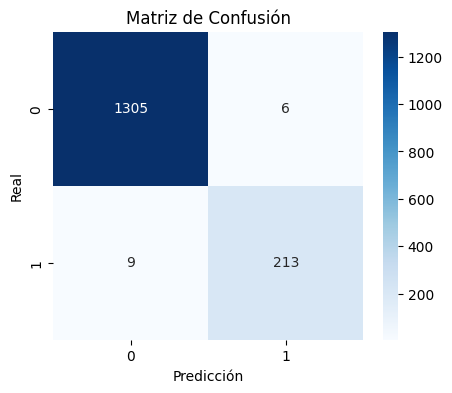

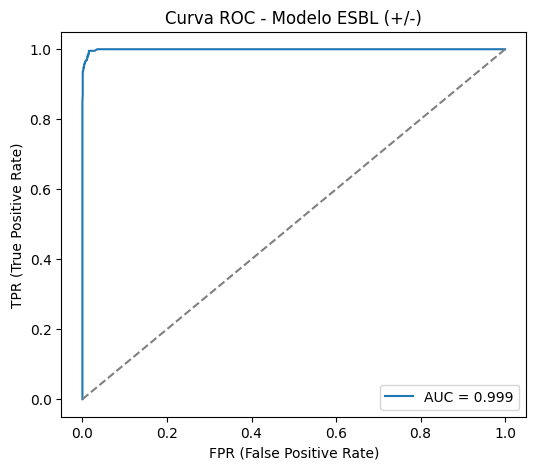

In [38]:
# Matriz de Confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Modelo ESBL (+/-)")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.show()